
# Asian Options Pricing & Hedging Tool
Course: FE 620: Pricing & Hedging | Stevens Institute of Technology

Advisor: Dan Pirjol

Group: Theo Dimitrasopoulos, Will Kraemer, Vaikunth Seshadri, Snehal Rajguru

Link: https://colab.research.google.com/drive/1g9xDGWCoKgFhNQWMW_nGfeJ8C1_5zaOE 

*Version: v6.0*

**Instructions:**\
Click the execution button on the top left corner of each code cell to execute it. To run all cells in descending order, go to the menu bar at the top and click Runtime -> Run all (or use the **Ctrl-F9** or **⌘-F9** hotkey for Windows and MacOSX respectively).

## Python Packages
*Note: the **"!pip install -q"** lines (i.e. lines 4-9) only need to be executed the first time you run the notebook. If you receive the message **"Requirement already satisfied:"**, wrap them in triple quotes (' ' ' in lines 3 & 10)*

In [0]:
# Install packages
# If you receive a series of "Requirement already satisfied:" messages during output, wrap them in triple quotes ( in lines 3 & 10)
'''
!pip install numpy
!pip install matplotlib
!pip install pandas-datareader
!pip install scipy
!pip install tensorflow
!pip install yfinance
'''
!pip install yfinance

# Import Packages
import random
import tensorflow as tf
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

## Inputs

### Underlying Asset Variables
Insert the desired values in the form fields (right) or directly to the code (left):

In [0]:
#@title Pricer Parameters:

# Initial Underlying Price
S0 =  100 #@param {type:"number"}

# Risk-free rate (also known as the drift coefficient)
r =  0.15#@param {type:"number"}

# Dividend Yield Rate
q =  0.0 #@param {type:"number"}

# Maturity
T =  1#@param {type:"number"}

# Strike
K =  95#@param {type:"number"}

# Volatility (also known as the diffusion coefficient)
sigma =  0.3 #@param {type:"number"}

# Number of Iterations for Monte Carlo Simulation
it =  10000#@param {type:"integer"}

# Time Steps
N =  10000#@param {type:"integer"}

# Risk-free rate
rf =  0.05 #@param {type:"number"}

### Plotting Parameters

In [0]:
#@title Element Sizes:

# Universal Plot width
width = 25 #@param {type:"integer"}

# Universal Plot height
height =  14#@param {type:"integer"}

# Universal xtick size
xtick_size = 8 #@param {type:"integer"}

# Universal ytick size
ytick_size =  8#@param {type:"integer"}

# Universal title font size
title_size = 18 #@param {type:"integer"}

# Universal xlabel font size
xlabel_size = 12 #@param {type:"integer"}

# Universal xlabel font size
ylabel_size = 12 #@param {type:"integer"}

# Universal legend font size
legend_size = 10 #@param {type:"integer"}

In [0]:
#Set parameters
plt.rcParams['figure.figsize'] = (width,height)
params = {'text.color' : 'black',
          'xtick.color' : 'w',
          'ytick.color' : 'w',
          'xtick.labelsize' : xtick_size,
          'ytick.labelsize' : ytick_size,
          'legend.loc' : 'upper left',
         }
plt.rcParams.update(params)

## Definitions

### Black-Scholes Geometric Option Price Calculator

In [0]:
def bs_geometric_call(r,q,T,K,S0,sigma):
  G0 = S0 * np.exp(0.5 * (r - q) * T - ((sigma**2) * T)/12)
  Sigma_G = sigma/np.sqrt(3)
  d1 = (1/(Sigma_G * np.sqrt(T))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * T)
  d2 = (1/(Sigma_G * np.sqrt(T))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * T)
  c = np.exp(-r * T) * (G0 * norm.cdf(d1) - K * norm.cdf(d2))
  return c

def bs_geometric_put(r,q,T,K,S0,sigma):
  G0 = S0 * np.exp(0.5 * (r - q) * T - ((sigma**2) * T)/12)
  Sigma_G = sigma/np.sqrt(3)
  d1 = (1/(Sigma_G * np.sqrt(T))) * (np.log(G0/K) + 0.5 * (Sigma_G**2) * T)
  d2 = (1/(Sigma_G * np.sqrt(T))) * (np.log(G0/K) - 0.5 * (Sigma_G**2) * T)
  p = np.exp(-r * T) * (K * norm.cdf(-d2) - G0 * norm.cdf(-d1))
  return p

### Brownian Motion Generator

In [0]:
def bm(rand, N):
  rand = np.random.randint(np.random.uniform(1.0,300.0), np.random.uniform(301.0,1000.0))
  np.random.seed(rand)
  dt = 1. / N
  b_dt = np.random.normal(0., 1., N)*np.sqrt(dt)
  W = np.cumsum(b_dt)
  return W, b_dt

### Geometric Brownian Motion Generator

In [0]:
def gbm(S0, r, sigma, T, N):      
  t = np.linspace(0.,1.,N+1)
  dt = 1. / N
  b_dt = np.random.normal(0., 1., N)*np.sqrt(dt)
  W = np.cumsum(b_dt)
  S = []
  S.append(S0)
  for i in range(1,N+1):
    S_i = S0 * np.exp((r - 0.5 * sigma**2) * t[i] + sigma * W[i-1])
    S.append(S_i)
  return S, t

## Monte Carlo Simulator

In [0]:
# Monte Carlo simulator for Call Options:
def mc_geometric_call(it,r,q,T,K,N,S0,sigma):      
  t = np.linspace(0.,1.,N)
  dt = 1. / N
  payoffs = []
  drift = r - 0.5*sigma**2
  for i in range(1,it):
    b_dt = np.random.normal(0., 1., N)*np.sqrt(dt)
    W = np.cumsum(b_dt)
    S = []
    S.append(S0)
    for j in range(1,N):
      S_j = S0 * np.exp(drift * t[j] + sigma * W[j-1])
      S.append(S_j)
    S_geom = np.exp(1/it*np.sum(np.log(S)))
    payoffs.append(np.max(S_geom - K,0))
  c = np.exp(-r * T)*np.mean(payoffs)
  return c, payoffs

# Monte Carlo simulator for Put Options:
def mc_geometric_put(it,r,q,T,K,N,S0,sigma):      
  t = np.linspace(0.,1.,N)
  dt = 1. / N
  payoffs = []
  drift = r - 0.5*sigma**2
  for i in range(1,it):
    b_dt = np.random.normal(0., 1., N)*np.sqrt(dt)
    W = np.cumsum(b_dt)
    S = []
    S.append(S0)
    for j in range(1,N):
      S_j = S0 * np.exp(drift * t[j] + sigma * W[j-1])
      S.append(S_j)
    S_geom = np.exp(1/N*np.sum(np.log(S)))
    payoffs.append(np.max(K - S_geom,0))
  p = np.exp(-r * T)*np.mean(payoffs)
  return p, payoffs

### Tensorflow implementation


In [0]:
'''
tf.compat.v1.disable_eager_execution()

def simulate_paths():
    S = tf.compat.v1.placeholder(tf.float32)
    K = tf.compat.v1.placeholder(tf.float32)
    dt = tf.compat.v1.placeholder(tf.float32)
    T = tf.compat.v1.placeholder(tf.float32)
    sigma = tf.compat.v1.placeholder(tf.float32)
    r = tf.compat.v1.placeholder(tf.float32)
    dw = tf.compat.v1.placeholder(tf.float32)
    S_T = S * tf.math.cumprod(tf.exp((r-sigma**2/2)*dt+sigma*tf.sqrt(dt)*dw), axis=1)
    return (S, K, dt, T, sigma, r, dw, S_T)

def mc_geometric_call_tf(enable_greeks = True):
    (S,K, dt, T, sigma, r, dw, S_T) = simulate_paths()
    A = tf.pow(tf.reduce_prod(S_T, axis=1),dt/T)
    payout = tf.maximum(A - K, 0)
    npv = tf.exp(-r*T) * tf.reduce_mean(payout)
    target_calc = [npv]
    if enable_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, T])
        target_calc += [greeks]
    def pricer(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, seed, n_sims, N):
        if seed != 0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, N)
        with tf.compat.v1.Session() as sess:
            timedelta = time_to_expiry / N
            res = sess.run(target_calc, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt : timedelta,
                               T: time_to_expiry,
                               dw : stdnorm_random_variates
                         })
            return res
    return pricer
 
mc_geometric_call_tf = mc_geometric_call_tf()
mc_geometric_call_tf(100, 100, 1, 0.3, 0.15, 1312, 10000000, 10)
'''

## Performance Tests

### Brownian Generator

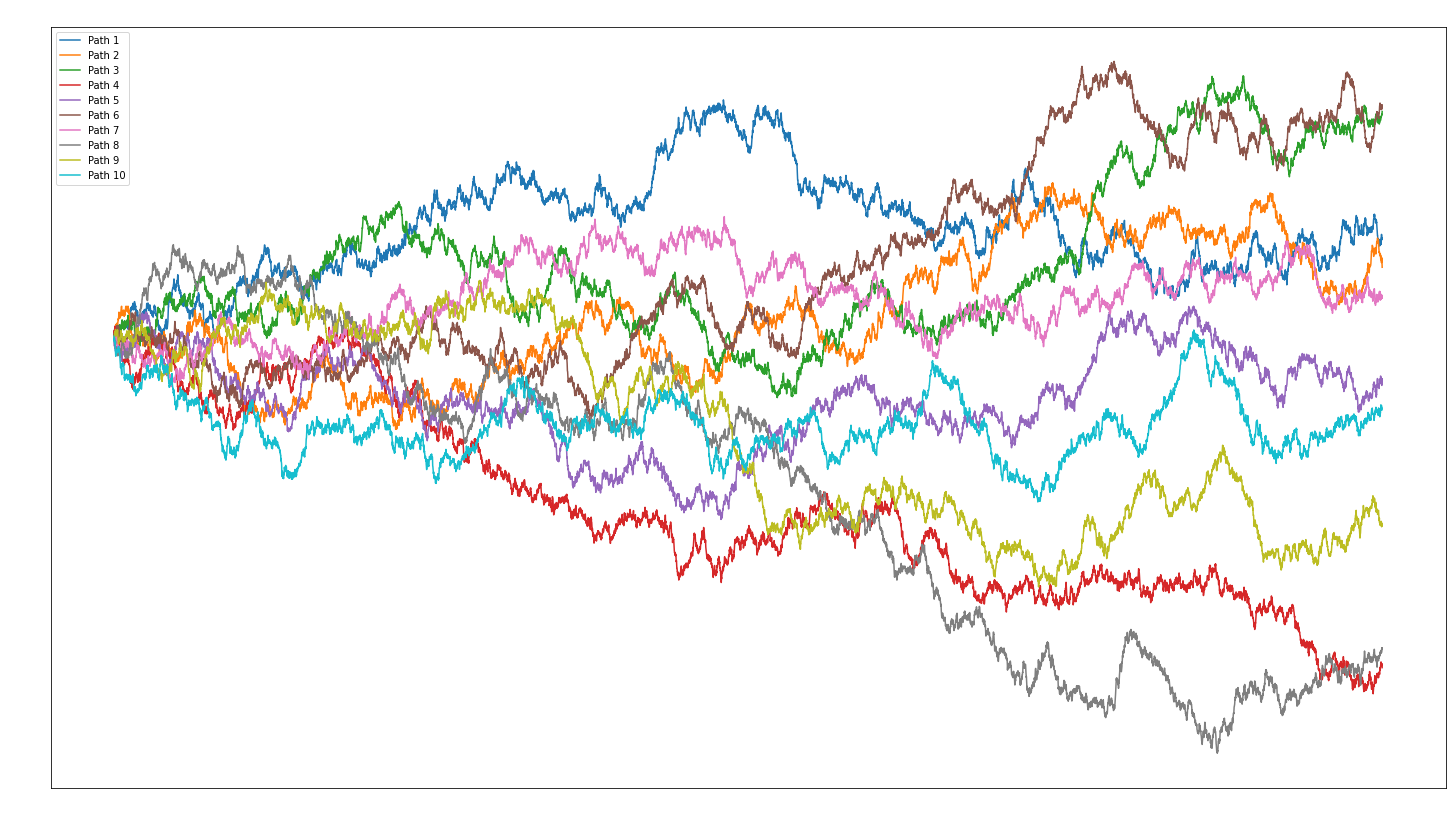

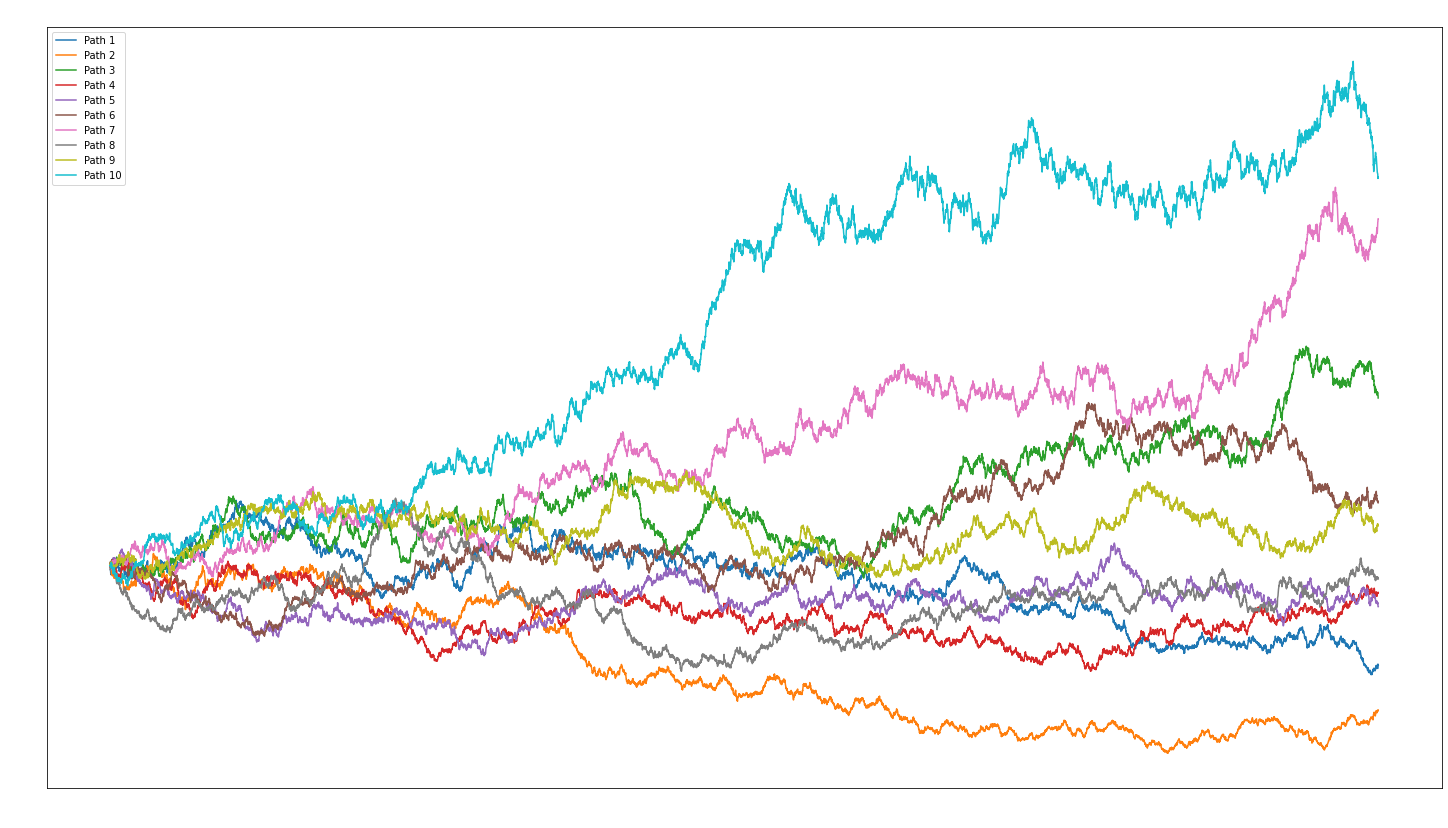

In [0]:
# Brownian Motion Generator Tests:
rand = random.random()
# Brownian Motion:
plt.title('Brownian Motion Paths',color='w',fontsize=title_size)
plt.xlabel('Time (1/N)',color='w',fontsize=xlabel_size)
plt.ylabel('Increments',color='w',fontsize=ylabel_size)
for i in range(1,11):
  plt.plot(bm(rand,N)[0],label='Path %d' %i)
plt.legend()
plt.show()

# Geometric Brownian Motion for 1 Asset:
plt.title('Potential Future Asset Price Paths',color='w',fontsize=title_size)
plt.xlabel('Time (1/N)',color='w',fontsize=xlabel_size)
plt.ylabel('Price ($)',color='w',fontsize=ylabel_size)
for i in range(1,11):
  plt.plot(gbm(S0, r, sigma, T, N)[0],label='Path %d' %i)
plt.legend()
plt.show()

### Black-Scholes Call

In [0]:
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

for i in range(95,110,5):
  print('The Black-Scholes geometric price of a Call Option with strike K = %d and maturity T=%d is: G_c(%d,%d)=' %(i,T,i,T), bs_geometric_call(r,q,T,i,S0,sigma))

print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
The Black-Scholes geometric price of a Call Option with strike K = 95 and maturity T=1 is: G_c(95,1)= 12.508538481017892
The Black-Scholes geometric price of a Call Option with strike K = 100 and maturity T=1 is: G_c(100,1)= 9.61215966961383
The Black-Scholes geometric price of a Call Option with strike K = 105 and maturity T=1 is: G_c(105,1)= 7.185865725921304
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


### Black-Scholes Put

In [0]:
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

for i in range(95,110,5):
  print('The Black-Scholes geometric price of a Put Option with strike K = %d and maturity T=%d is: G_p(%d,%d)=' %(i,T,i,T), bs_geometric_put(r,q,T,i,S0,sigma))

print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
The Black-Scholes geometric price of a Put Option with strike K = 95 and maturity T=1 is: G_p(95,1)= 2.194652455717922
The Black-Scholes geometric price of a Put Option with strike K = 100 and maturity T=1 is: G_p(100,1)= 3.6018135264391438
The Black-Scholes geometric price of a Put Option with strike K = 105 and maturity T=1 is: G_p(105,1)= 5.479059464871914
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


### Monte Carlo Call

In [0]:
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
# Monte Carlo Simulator for Call Options:

for i in range(95,110,5):
  print('The Monte Carlo geometric price of a Call Option with strike K = %d and maturity T=%d is: G_c(%d,%d)=' %(i,T,i,T), mc_geometric_call(it,r,q,T,i,N,S0,sigma)[0])

print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
The Monte Carlo geometric price of a Call Option with strike K = 95 and maturity T=1 is: G_c(95,1)= 10.212255611327029
The Monte Carlo geometric price of a Call Option with strike K = 100 and maturity T=1 is: G_c(100,1)= 6.43324759483176
The Monte Carlo geometric price of a Call Option with strike K = 105 and maturity T=1 is: G_c(105,1)= 1.630099962084275
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


### Monte Carlo Put

In [0]:
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
# Monte Carlo Simulator for Put Options:

for i in range(95,110,5):
  print('The Monte Carlo geometric price of a Put Option with strike K = %d and maturity T=%d is: G_p(%d,%d)=' %(i,T,i,T), mc_geometric_put(it,r,q,T,i,N,S0,sigma)[0])

print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
The Monte Carlo geometric price of a Put Option with strike K = 95 and maturity T=1 is: G_p(95,1)= -10.32853327489744


## Market Data

### Plot Data

In [0]:
#@title Historical Data Parameters:

#Start date of historical data
start_date = "1995-01-01" #@param {type:"date"}
#End date of historical data
end_date = "2020-04-09" #@param {type:"date"}
# Type of historical data
data_type = "Adj Close" #@param ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

### Random assortment of stocks

In [0]:
market_data_real_random = plt.figure()
msft = pdr.get_data_yahoo("MSFT",start = start_date,end = end_date)[data_type]
plt.plot(msft,label='Microsoft (MSFT)')

aapl = pdr.get_data_yahoo("AAPL",start = start_date,end = end_date)[data_type]
plt.plot(aapl,label='Apple (AAPL)')

gs = pdr.get_data_yahoo("GS",start = start_date,end = end_date)[data_type]
plt.plot(gs,label='Goldman Sachs (GS)')

nflx = pdr.get_data_yahoo("NFLX",start = start_date,end = end_date)[data_type]
plt.plot(nflx,label='Netflix (NFLX)')

fb = pdr.get_data_yahoo("FB",start = start_date,end = end_date)[data_type]
plt.plot(fb,label='Facebook (FB)')

f = pdr.get_data_yahoo("F",start = start_date,end = end_date)[data_type]
plt.plot(f,label='Ford (F)')

twtr = pdr.get_data_yahoo("TWTR",start = start_date,end = end_date)[data_type]
plt.plot(twtr,label='Twitter (TWTR)')

ibm = pdr.get_data_yahoo("IBM",start = start_date,end = end_date)[data_type]
plt.plot(ibm,label='IBM (IBM)')

baba = pdr.get_data_yahoo("BABA",start = start_date,end = end_date)[data_type]
plt.plot(baba,label='Alibaba (BABA)')

ba = pdr.get_data_yahoo("BA",start = start_date,end = end_date)[data_type]
plt.plot(ba,label='Boeing (BA)')

cme = pdr.get_data_yahoo("CME",start = start_date,end = end_date)[data_type]
plt.plot(cme,label='Chicago Mercantile Exchange (CME)')

# Citi never quite recovered from the downfall (staggering losses around 2008 and no subsequent rebound)
c = pdr.get_data_yahoo("C",start = start_date,end = end_date)[data_type]
plt.plot(c,label='Citigroup (C)')

ttl1 = "Historical"
ttl2 = data_type
ttl3 = "of selected Securities"
title = " ".join((ttl1, ttl2, ttl3))
plt.title(title,color='w',fontsize=title_size)
plt.xlabel('Date',color='w',fontsize=xlabel_size)

if data_type == "Volume":
  ylab = data_type + " (#)"
else:
  ylab = data_type + " ($)"

plt.ylabel(ylab,color='w',fontsize=ylabel_size)
plt.legend()
plt.show()

### Dow 30 stocks

In [0]:
market_data_real_dow30 = plt.figure()
mmm = pdr.get_data_yahoo("MMM",start = start_date,end = end_date)[data_type]
plt.plot(mmm,label='3M (MMM)')

axp = pdr.get_data_yahoo("AXP",start = start_date,end = end_date)[data_type]
plt.plot(axp,label='American Express (AXP)')

baba = pdr.get_data_yahoo("BABA",start = start_date,end = end_date)[data_type]
plt.plot(baba,label='Alibaba (BABA)')

aapl = pdr.get_data_yahoo("AAPL",start = start_date,end = end_date)[data_type]
plt.plot(aapl,label='Apple (AAPL)')

ba = pdr.get_data_yahoo("BA",start = start_date,end = end_date)[data_type]
plt.plot(ba,label='Boeing (BA)')

cat = pdr.get_data_yahoo("CAT",start = start_date,end = end_date)[data_type]
plt.plot(cat,label='Caterpillar (CAT)')

cvx = pdr.get_data_yahoo("CVX",start = start_date,end = end_date)[data_type]
plt.plot(cvx,label='Chevron (CVX)')

csco = pdr.get_data_yahoo("CSCO",start = start_date,end = end_date)[data_type]
plt.plot(csco,label='Cisco (CSCO)')

ko = pdr.get_data_yahoo("KO",start = start_date,end = end_date)[data_type]
plt.plot(ko,label='Coca Cola (KO)')

dis = pdr.get_data_yahoo("DIS",start = start_date,end = end_date)[data_type]
plt.plot(dis,label='The Walt Disney Company (DIS)')

dd = pdr.get_data_yahoo("DD",start = start_date,end = end_date)[data_type]
plt.plot(dd,label='DowDuPont (DD)')

xom = pdr.get_data_yahoo("XOM",start = start_date,end = end_date)[data_type]
plt.plot(xom,label='ExxonMobil (XOM)')

ge = pdr.get_data_yahoo("GE",start = start_date,end = end_date)[data_type]
plt.plot(ge,label='General Electric (GE)')

gs = pdr.get_data_yahoo("GS",start = start_date,end = end_date)[data_type]
plt.plot(gs,label='Goldman Sachs (GS)')

hd = pdr.get_data_yahoo("HD",start = start_date,end = end_date)[data_type]
plt.plot(hd,label='The Home Depot (HD)')

ibm = pdr.get_data_yahoo("IBM",start = start_date,end = end_date)[data_type]
plt.plot(ibm,label='IBM (IBM)')

intc = pdr.get_data_yahoo("INTC",start = start_date,end = end_date)[data_type]
plt.plot(intc,label='Intel (INTC)')

jnj = pdr.get_data_yahoo("JNJ",start = start_date,end = end_date)[data_type]
plt.plot(jnj,label='Johnson & Johnson (JNJ)')

jpm = pdr.get_data_yahoo("JPM",start = start_date,end = end_date)[data_type]
plt.plot(jpm,label='JPMorgan Chase (JPM)')

mcd = pdr.get_data_yahoo("MCD",start = start_date,end = end_date)[data_type]
plt.plot(mcd,label='McDonalds (MCD)')

mrk = pdr.get_data_yahoo("MRK",start = start_date,end = end_date)[data_type]
plt.plot(mrk,label='Merck (MRK)')

msft = pdr.get_data_yahoo("MSFT",start = start_date,end = end_date)[data_type]
plt.plot(msft,label='Microsoft (MSFT)')

nke = pdr.get_data_yahoo("NKE",start = start_date,end = end_date)[data_type]
plt.plot(nke,label='Nike (NKE)')

pfe = pdr.get_data_yahoo("PFE",start = start_date,end = end_date)[data_type]
plt.plot(pfe,label='Pfizer (PFE)')

pg = pdr.get_data_yahoo("PG",start = start_date,end = end_date)[data_type]
plt.plot(pg,label='Procter & Gamble (PG)')

trv = pdr.get_data_yahoo("TRV",start = start_date,end = end_date)[data_type]
plt.plot(trv,label='Travelers Companies, Inc (TRV)')

utx = pdr.get_data_yahoo("UTX",start = start_date,end = end_date)[data_type]
plt.plot(utx,label='United Technologies (UTX)')

unh = pdr.get_data_yahoo("UNH",start = start_date,end = end_date)[data_type]
plt.plot(unh,label='United Health (UNH)')

vz = pdr.get_data_yahoo("VZ",start = start_date,end = end_date)[data_type]
plt.plot(vz,label='Verizon (VZ)')

v = pdr.get_data_yahoo("V",start = start_date,end = end_date)[data_type]
plt.plot(v,label='Visa (V)')

wmt = pdr.get_data_yahoo("WMT",start = start_date,end = end_date)[data_type]
plt.plot(wmt,label='Wal-Mart (WMT)')

ttl1 = "Historical"
ttl2 = data_type
ttl3 = "of the Dow 30"
title = " ".join((ttl1, ttl2, ttl3))
plt.title(title,color='w',fontsize=title_size)
plt.xlabel('Date',color='w',fontsize=xlabel_size)

if data_type == "Volume":
  ylab = data_type + " (#)"
else:
  ylab = data_type + " ($)"

plt.ylabel(ylab,color='w',fontsize=ylabel_size)
plt.legend()
plt.show()